In [6]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import numpy as np
import yfinance as yf
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

import folium
from folium.plugins import MarkerCluster

import os
os.environ["OMP_NUM_THREADS"] = "2"


import warnings
warnings.filterwarnings("ignore")

In [7]:
#### Obtendo o preço do Dólar diário

##### Base de reserva caso o yfinance não responda

In [92]:
dolar = pd.read_csv('preco_dolar.csv')

# Criar o dataframe com as colunas desejadas

dolar = dolar[['Date', 'Close']] 
dolar = dolar.rename(columns={'Date': 'data','Close': 'dolar'})
# Certificar-se de que a coluna está no formato datetime
dolar["data"] = pd.to_datetime(dolar["data"], utc=True)

dolar["data"] = dolar["data"].dt.strftime("%Y-%m-%d")
dolar["data"] = pd.to_datetime(dolar["data"], format="%Y-%m-%d")


dolar.count()

data     2606
dolar    2606
dtype: int64

In [93]:
dolar["data"].min(), dolar["data"].max()

(Timestamp('2015-02-19 00:00:00'), Timestamp('2025-02-19 00:00:00'))

##### yfinance

In [8]:
# Obter o histórico do dólar (USD/BRL)

ticker = 'USDBRL=X'  # Símbolo do câmbio Dólar/Real
#ticker = 'BRL=X' 
data = yf.Ticker(ticker)
historico = data.history(period="10y")  # Últimos 10 anos

print(historico[['Open', 'High', 'Low', 'Close']])

                             Open    High       Low   Close
Date                                                       
2015-02-19 00:00:00+00:00  2.8345  2.8638  2.819200  2.8340
2015-02-20 00:00:00+00:00  2.8629  2.8808  2.849500  2.8633
2015-02-23 00:00:00+00:00  2.8641  2.8976  2.859700  2.8641
2015-02-24 00:00:00+00:00  2.8755  2.8822  2.853400  2.8747
2015-02-25 00:00:00+00:00  2.8547  2.8794  2.828100  2.8570
...                           ...     ...       ...     ...
2025-02-13 00:00:00+00:00  5.7644  5.7982  5.753031  5.7644
2025-02-14 00:00:00+00:00  5.7669  5.7984  5.707000  5.7669
2025-02-17 00:00:00+00:00  5.7012  5.7290  5.693500  5.7012
2025-02-18 00:00:00+00:00  5.7121  5.7258  5.674600  5.7121
2025-02-19 00:00:00+00:00  5.6926  5.7324  5.676700  5.7214

[2606 rows x 4 columns]


In [9]:
# Criar o dataframe com as colunas desejadas
dolar = historico[['Close']].reset_index()
dolar.columns = ['data', 'dolar']
dolar['data'] = dolar['data'].dt.strftime('%d/%m/%Y')

# Converter a coluna 'data' em ambos os dataframes para o formato datetime
dolar['data'] = pd.to_datetime(dolar['data'], format='%d/%m/%Y')

dolar.head(3)

data   dolar
0 2015-02-19  2.8340
1 2015-02-20  2.8633
2 2015-02-23  2.8641

#### DataFrame com os preços diários de combustíveis

In [10]:
# Carrega o arquivo CSV kaggle
cidades = pd.read_csv("gasolina_fortaleza_2016-2024_v3.csv", sep=',')  # Substitua pelo caminho correto do arquivo
cidades['data'] = pd.to_datetime(cidades['data'], errors='coerce')
cidades

Estado - Sigla  Municipio  \
0                 CE  FORTALEZA   
1                 CE  FORTALEZA   
2                 CE  FORTALEZA   
3                 CE  FORTALEZA   
4                 CE  FORTALEZA   
...              ...        ...   
36703             CE  FORTALEZA   
36704             CE  FORTALEZA   
36705             CE  FORTALEZA   
36706             CE  FORTALEZA   
36707             CE  FORTALEZA   

                                                 Revenda      CNPJ da Revenda  \
0            DIAS COMERCIO DE DERIVADOS DE PETROLEO LTDA   08.509.458/0001-82   
1                    IGUATEMI DERIVADOS DE PETROLEO LTDA   07.304.199/0003-52   
2                         SOBRAL & PALACIO PETROLEO LTDA   07.240.641/0002-43   
3          ,SOUSA & RIBAS COMÉRCIO DE COMBUSTÍVEIS LTDA.   07.796.363/0001-24   
4                                 POSTO ATAPÚ LTDA - EPP   02.050.428/0001-74   
...                                                  ...                  ...   
36703   J.B.  COMERCIO DE COMBUSTIVEIS E TRANSPORTE LTDA   21.786.390/0001-47   
36704                M & L COMERCIO DE COMBUSTIVEIS LTDA   22.337.553/0001-77   
36705                                      POSTO JP LTDA   25.306.266/0001-98   
36706  MONTREAL MONTESE COMERCIO DE COMBUSTIVEIS E LU...   04.787.688/0001-52   
36707    MACK XII COMERCIO DE DERIVADOS DE PETROLEO LTDA   35.830.851/0001-46   

                            Nome da Rua Numero Rua Complemento  \
0      RODOVIA DOUTOR MENDEL STEINBRUCH       6750         NaN   
1               AVENIDA OSORIO DE PAIVA       6800         NaN   
2                    AVENIDA 13 DE MAIO        233           0   
3               AVENIDA HERACLITO GRAÇA         20         NaN   
4        AVENIDA VISCONDE DO RIO BRANCO       3826           B   
...                                 ...        ...         ...   
36703         AVENIDA AUGUSTO DOS ANJOS        472         NaN   
36704     AVENIDA RADIALISTA JOAO RAMOS       2296       POSTO   
36705          AVENIDA GODOFREDO MACIEL       3959      4015 A   
36706               AVENIDA JOAO PESSOA       6094         NaN   
36707               AVENIDA JOAO PESSOA       4901         NaN   

                      Bairro        Cep   Produto  Valor de Venda  \
0                    ARACAPE  60765-005  GASOLINA            3.89   
1                   SIQUEIRA  60720-001  GASOLINA            3.89   
2                     FATIMA  60040-530  GASOLINA            3.89   
3                     CENTRO  60140-060  GASOLINA            3.82   
4         SÃO JOÃO DO TAUAPÉ  60035-170  GASOLINA            3.87   
...                      ...        ...       ...             ...   
36703              PARANGABA  60720-605  GASOLINA            6.39   
36704  PLANALTO AYRTON SENNA  60766-710  GASOLINA            6.37   
36705               MONDUBIM  60711-495  GASOLINA            6.37   
36706                MONTESE  60440-005  GASOLINA            6.35   
36707                  DAMAS  60425-813  GASOLINA            6.37   

      Unidade de Medida  Bandeira       data  \
0            R$ / litro    RAIZEN 2016-01-05   
1            R$ / litro  IPIRANGA 2016-01-06   
2            R$ / litro    RAIZEN 2016-01-05   
3            R$ / litro        SP 2016-01-05   
4            R$ / litro        SP 2016-01-05   
...                 ...       ...        ...   
36703        R$ / litro    RAIZEN 2024-12-28   
36704        R$ / litro     VIBRA 2024-12-28   
36705        R$ / litro     VIBRA 2024-12-28   
36706        R$ / litro     VIBRA 2024-12-28   
36707        R$ / litro  IPIRANGA 2024-12-28   

                                                endereco  Latitude  Longitude  
0      RODOVIA DOUTOR MENDEL STEINBRUCH, 6750 - ARACA... -3.835756 -38.585207  
1      AVENIDA OSORIO DE PAIVA, 6800 - SIQUEIRA - FOR... -3.813689 -38.613696  
2           AVENIDA 13 DE MAIO, 233 - FATIMA - FORTALEZA -3.754333 -38.526521  
3       AVENIDA HERACLITO GRAÇA, 20 - CENTRO - FORTALEZA       NaN        NaN  
4      AVENID

In [11]:
cidades['data'].min(), cidades['data'].max()

(Timestamp('2016-01-05 00:00:00'), Timestamp('2024-12-28 00:00:00'))

#### Concatenando os preços dos combustíveis com os valores do dólar diários

In [12]:
# Realizar o merge pela coluna 'data'
df_merge = pd.merge(cidades, dolar, on='data', how='inner')

#### Selecionando apenas coordenadas que fazem parte do ceará

In [13]:
df = df_merge.copy()
lat_min, lat_max = -7.83, -2.71
lon_min, lon_max = -41.55, -34.67

# Identificar coordenadas DENTRO do Ceará
df['dentro_do_ceara'] = (df['Latitude'].between(lat_min, lat_max)) & \
                        (df['Longitude'].between(lon_min, lon_max))

# Filtrar as linhas com coordenadas DENTRO do Ceará
df_dentro_ceara = df[df['dentro_do_ceara']== True]

df_dentro_ceara.head(3)

Estado - Sigla  Municipio                                      Revenda  \
0             CE  FORTALEZA  DIAS COMERCIO DE DERIVADOS DE PETROLEO LTDA   
1             CE  FORTALEZA          IGUATEMI DERIVADOS DE PETROLEO LTDA   
2             CE  FORTALEZA               SOBRAL & PALACIO PETROLEO LTDA   

       CNPJ da Revenda                       Nome da Rua Numero Rua  \
0   08.509.458/0001-82  RODOVIA DOUTOR MENDEL STEINBRUCH       6750   
1   07.304.199/0003-52           AVENIDA OSORIO DE PAIVA       6800   
2   07.240.641/0002-43                AVENIDA 13 DE MAIO        233   

  Complemento    Bairro        Cep   Produto  Valor de Venda  \
0         NaN   ARACAPE  60765-005  GASOLINA            3.89   
1         NaN  SIQUEIRA  60720-001  GASOLINA            3.89   
2           0    FATIMA  60040-530  GASOLINA            3.89   

  Unidade de Medida  Bandeira       data  \
0        R$ / litro    RAIZEN 2016-01-05   
1        R$ / litro  IPIRANGA 2016-01-06   
2        R$ / litro    RAIZEN 2016-01-05   

                                            endereco  Latitude  Longitude  \
0  RODOVIA DOUTOR MENDEL STEINBRUCH, 6750 - ARACA... -3.835756 -38.585207   
1  AVENIDA OSORIO DE PAIVA, 6800 - SIQUEIRA - FOR... -3.813689 -38.613696   
2       AVENIDA 13 DE MAIO, 233 - FATIMA - FORTALEZA -3.754333 -38.526521   

    dolar  dentro_do_ceara  
0  4.0373             True  
1  4.0269             True  
2  4.0373             True

In [14]:
df_preco = df_dentro_ceara.copy()

# Renomeia a coluna 'mean' para 'preco'
df_preco = df_preco.rename(columns={'CNPJ da Revenda': 'cnpj', 'Valor de Venda': 'preco', 'Bandeira': 'bandeira', 'Latitude': 'latitude', 'Longitude': 'longitude'})

# Exibe o novo dataframe
df_preco.head(3)

Estado - Sigla  Municipio                                      Revenda  \
0             CE  FORTALEZA  DIAS COMERCIO DE DERIVADOS DE PETROLEO LTDA   
1             CE  FORTALEZA          IGUATEMI DERIVADOS DE PETROLEO LTDA   
2             CE  FORTALEZA               SOBRAL & PALACIO PETROLEO LTDA   

                  cnpj                       Nome da Rua Numero Rua  \
0   08.509.458/0001-82  RODOVIA DOUTOR MENDEL STEINBRUCH       6750   
1   07.304.199/0003-52           AVENIDA OSORIO DE PAIVA       6800   
2   07.240.641/0002-43                AVENIDA 13 DE MAIO        233   

  Complemento    Bairro        Cep   Produto  preco Unidade de Medida  \
0         NaN   ARACAPE  60765-005  GASOLINA   3.89        R$ / litro   
1         NaN  SIQUEIRA  60720-001  GASOLINA   3.89        R$ / litro   
2           0    FATIMA  60040-530  GASOLINA   3.89        R$ / litro   

   bandeira       data                                           endereco  \
0    RAIZEN 2016-01-05  RODOVIA DOUTOR MENDEL STEINBRUCH, 6750 - ARACA...   
1  IPIRANGA 2016-01-06  AVENIDA OSORIO DE PAIVA, 6800 - SIQUEIRA - FOR...   
2    RAIZEN 2016-01-05       AVENIDA 13 DE MAIO, 233 - FATIMA - FORTALEZA   

   latitude  longitude   dolar  dentro_do_ceara  
0 -3.835756 -38.585207  4.0373             True  
1 -3.813689 -38.613696  4.0269             True  
2 -3.754333 -38.526521  4.0373             True

#### Selecioando inicialmente as features que vamos utilizar

In [15]:
df_inicial = df_preco.copy()
df_inicial = df_inicial[["cnpj","data", "latitude", "longitude", "bandeira", "dolar", "preco"]]
df_inicial

cnpj       data  latitude  longitude  \
0       08.509.458/0001-82 2016-01-05 -3.835756 -38.585207   
1       07.304.199/0003-52 2016-01-06 -3.813689 -38.613696   
2       07.240.641/0002-43 2016-01-05 -3.754333 -38.526521   
5       08.070.842/0001-21 2016-01-05 -3.790185 -38.580618   
6       08.454.186/0001-60 2016-01-05 -3.748463 -38.515856   
...                    ...        ...       ...        ...   
33951   20.917.923/0001-10 2024-12-27 -3.797017 -38.520679   
33952   14.496.482/0001-27 2024-12-27 -3.792244 -38.519883   
33953   09.455.725/0001-49 2024-12-27 -3.843692 -38.528754   
33954   24.113.139/0001-00 2024-12-27 -3.803055 -38.530760   
33955   24.566.347/0001-64 2024-12-27 -3.783366 -38.625364   

                           bandeira   dolar  preco  
0                            RAIZEN  4.0373   3.89  
1                          IPIRANGA  4.0269   3.89  
2                            RAIZEN  4.0373   3.89  
5                            ALESAT  4.0373   3.87  
6      PETROBRAS DISTRIBUIDORA S.A.  4.0373   3.87  
...                             ...     ...    ...  
33951                        RAIZEN  6.1485   6.39  
33952                      IPIRANGA  6.1485   6.39  
33953                      IPIRANGA  6.1485   6.35  
33954                        BRANCA  6.1485   6.39  
33955                        RAIZEN  6.1485   6.37  

[32469 rows x 7 columns]

#### Selecionando apenas postos que estão presentes em todos os anos

In [16]:
# Extraia o ano da coluna 'data'
df_inicial['ano'] = df_inicial['data'].dt.year

# Identifique os anos únicos no dataset
anos_unicos = df_inicial['ano'].unique()

In [17]:
# Filtrar apenas os CNPJs que estão presentes em todos os anos
cnpjs_completos = (
    df_inicial.groupby('cnpj')['ano']
    .nunique()  # Conta os anos distintos para cada CNPJ
    .loc[lambda x: x == len(anos_unicos)]  # Seleciona os CNPJs presentes em todos os anos
    .index  # Pega apenas os índices (CNPJs)
)

In [18]:
# Filtrar o DataFrame original para incluir apenas os CNPJs completos
df_filtrado = df_inicial[df_inicial['cnpj'].isin(cnpjs_completos)]

df_filtrado['preco_ajustado'] = df_filtrado['preco'] / df_filtrado['dolar']

df_filtrado


cnpj       data  latitude  longitude  \
1       07.304.199/0003-52 2016-01-06 -3.813689 -38.613696   
7       07.857.332/0001-36 2016-01-05 -3.752016 -38.512243   
12      06.352.771/0001-24 2016-01-05 -3.757896 -38.522169   
17      04.833.441/0001-25 2016-01-05 -3.753259 -38.522712   
20      09.496.274/0001-98 2016-01-05 -3.723755 -38.522341   
...                    ...        ...       ...        ...   
33945   04.934.167/0001-80 2024-12-27 -3.831513 -38.583771   
33947   02.696.818/0009-73 2024-12-27 -3.812220 -38.531190   
33948   10.658.840/0001-08 2024-12-27 -3.852504 -38.502641   
33949   11.294.662/0001-38 2024-12-27 -3.783955 -38.625907   
33950   18.314.274/0001-10 2024-12-27 -3.821829 -38.537778   

                           bandeira   dolar  preco   ano  preco_ajustado  
1                          IPIRANGA  4.0269  3.890  2016        0.966004  
7      PETROBRAS DISTRIBUIDORA S.A.  4.0373  3.880  2016        0.961038  
12                           ALESAT  4.0373  3.890  2016        0.963515  
17                           RAIZEN  4.0373  3.879  2016        0.960791  
20                         IPIRANGA  4.0373  3.879  2016        0.960791  
...                             ...     ...    ...   ...             ...  
33945                            SP  6.1485  6.390  2024        1.039278  
33947                            SP  6.1485  6.390  2024        1.039278  
33948                        BRANCA  6.1485  6.350  2024        1.032772  
33949                            SP  6.1485  6.380  2024        1.037651  
33950                        RAIZEN  6.1485  6.590  2024        1.071806  

[16066 rows x 9 columns]

#### Agrupando os dados e criando variáveis para resumir a variabilidade e também para facilitar a identificação de padrões nos clusters

In [19]:
# Realize o agrupamento e os cálculos necessários
df_agrup = (
    df_filtrado.groupby(['cnpj', 'latitude', 'longitude', 'bandeira', 'ano'])
    .agg(
        media_preco=('preco', 'mean'),
        minimo_preco=('preco', 'min'),
        maximo_preco=('preco', 'max'),
        desvio_padrao_preco=('preco', 'std'),
        media_dolar=('dolar', 'mean'),  # Adiciona a média do dólar
        media_preco_ajustador=('preco_ajustado', 'mean'),  # Adiciona a média do dólar
        minimo_preco_ajustado=('preco_ajustado', 'min'),
        maximo_preco_ajustado=('preco_ajustado', 'max')
    )
    .reset_index()
)

# Substituir NaN no desvio padrão por 0, já que não há variação
df_agrup['desvio_padrao_preco'] = df_agrup['desvio_padrao_preco'].fillna(0)
df_agrup['amplitude_preco'] = df_agrup['maximo_preco']-df_agrup['minimo_preco']


# Resultado final
df_agrup

cnpj  latitude  longitude                      bandeira  \
0      00.192.116/0001-70 -3.757513 -38.534735  PETROBRAS DISTRIBUIDORA S.A.   
1      00.192.116/0001-70 -3.757513 -38.534735  PETROBRAS DISTRIBUIDORA S.A.   
2      00.192.116/0001-70 -3.757513 -38.534735  PETROBRAS DISTRIBUIDORA S.A.   
3      00.192.116/0001-70 -3.757513 -38.534735  PETROBRAS DISTRIBUIDORA S.A.   
4      00.192.116/0001-70 -3.757513 -38.534735  PETROBRAS DISTRIBUIDORA S.A.   
...                   ...       ...        ...                           ...   
1197   86.870.680/0001-10 -3.764650 -38.512675                      IPIRANGA   
1198   86.870.680/0001-10 -3.764650 -38.512675                      IPIRANGA   
1199   86.870.680/0001-10 -3.764650 -38.512675                      IPIRANGA   
1200   86.870.680/0001-10 -3.764650 -38.512675                      IPIRANGA   
1201   86.870.680/0001-10 -3.764650 -38.512675                      IPIRANGA   

       ano  media_preco  minimo_preco  maximo_preco  desvio_padrao_preco  \
0     2016     3.918214         3.830         3.999             0.061105   
1     2017     3.912200         3.459         4.210             0.183208   
2     2018     4.523500         4.270         4.799             0.184516   
3     2019     4.515625         4.090         4.780             0.207299   
4     2020     4.489632         3.999         4.799             0.243641   
...    ...          ...           ...           ...                  ...   
1197  2020     4.369813         3.899         4.689             0.292803   
1198  2021     5.645000         5.468         5.999             0.306573   
1199  2022     4.790000         4.790         4.790             0.000000   
1200  2023     5.760000         5.760         5.760             0.000000   
1201  2024     5.890000         5.890         5.890             0.000000   

      media_dolar  media_preco_ajustador  minimo_preco_ajustado  \
0        3.481493               1.131201               0.960399   
1        3.180527               1.230315               1.104477   
2        3.655883               1.242953               1.099933   
3        3.951906               1.143082               1.072243   
4        5.049353               0.902793               0.682983   
...           ...                    ...                    ...   
1197     5.065555               0.875315               0.705229   
1198     5.564319               1.017600               0.930787   
1199     5.146300               0.930766               0.930766   
1200     5.213483               1.104828               1.104828   
1201     4.975700               1.183753               1.183753   

      maximo_preco_ajustado  amplitude_preco  
0                  1.222040            0.169  
1                  1.293792            0.751  
2                  1.355357            0.529  
3                  1.207487            0.690  
4                  1.181205            0.800  
...                     ...              ...  
1197               1.162698            0.790  
1198               1.126954            0.531  
1199               0.930766            0.000  
1200               1.104828            0.000  
1201               1.183753            0.000  

[1202 rows x 14 columns]

In [20]:
df_agrup['ano'] = pd.to_numeric(df_agrup['ano'], errors='coerce')
df_agrup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202 entries, 0 to 1201
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   cnpj                   1202 non-null   object 
 1   latitude               1202 non-null   float64
 2   longitude              1202 non-null   float64
 3   bandeira               1202 non-null   object 
 4   ano                    1202 non-null   int32  
 5   media_preco            1202 non-null   float64
 6   minimo_preco           1202 non-null   float64
 7   maximo_preco           1202 non-null   float64
 8   desvio_padrao_preco    1202 non-null   float64
 9   media_dolar            1202 non-null   float64
 10  media_preco_ajustador  1202 non-null   float64
 11  minimo_preco_ajustado  1202 non-null   float64
 12  maximo_preco_ajustado  1202 non-null   float64
 13  amplitude_preco        1202 non-null   float64
dtypes: float64(11), int32(1), object(2)
memory usage: 126.9+

In [21]:
df = df_agrup.copy()
df.head(3)

cnpj  latitude  longitude                      bandeira  \
0   00.192.116/0001-70 -3.757513 -38.534735  PETROBRAS DISTRIBUIDORA S.A.   
1   00.192.116/0001-70 -3.757513 -38.534735  PETROBRAS DISTRIBUIDORA S.A.   
2   00.192.116/0001-70 -3.757513 -38.534735  PETROBRAS DISTRIBUIDORA S.A.   

    ano  media_preco  minimo_preco  maximo_preco  desvio_padrao_preco  \
0  2016     3.918214         3.830         3.999             0.061105   
1  2017     3.912200         3.459         4.210             0.183208   
2  2018     4.523500         4.270         4.799             0.184516   

   media_dolar  media_preco_ajustador  minimo_preco_ajustado  \
0     3.481493               1.131201               0.960399   
1     3.180527               1.230315               1.104477   
2     3.655883               1.242953               1.099933   

   maximo_preco_ajustado  amplitude_preco  
0               1.222040            0.169  
1               1.293792            0.751  
2               1.355357            0.529

In [22]:
df.count()

cnpj                     1202
latitude                 1202
longitude                1202
bandeira                 1202
ano                      1202
media_preco              1202
minimo_preco             1202
maximo_preco             1202
desvio_padrao_preco      1202
media_dolar              1202
media_preco_ajustador    1202
minimo_preco_ajustado    1202
maximo_preco_ajustado    1202
amplitude_preco          1202
dtype: int64

### GMM

### Vamos criar um modelo de GMM para cada ano e para cada ano escolher o melhor número de clusters pelo critério de minimização do BIC

In [23]:
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

In [24]:
# Lista para armazenar os resultados de cada ano
results = []

#### Criação de Outliers
 - Criamos a variável is_outlier que utiliza a log-verossimilhança para categorizar a amostra como outlier ou não
 - Quanto maior a log-verossimilhança mais provável de pertencer a aquele cluster
 - Calculamos o percentil 5%, ou seja, os 5% menores valores da log-verossimilhança e escolhemos este limiar para definir quais pontos são outliers.

Processando o ano: 2016
Ano 2016: Melhor número de clusters = 5


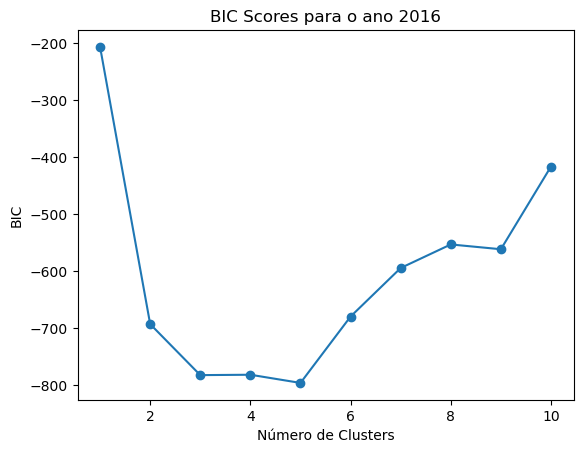

Processando o ano: 2017
Ano 2017: Melhor número de clusters = 2


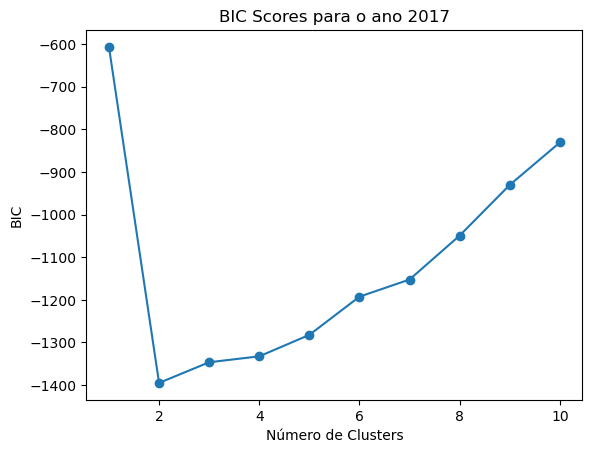

Processando o ano: 2018
Ano 2018: Melhor número de clusters = 4


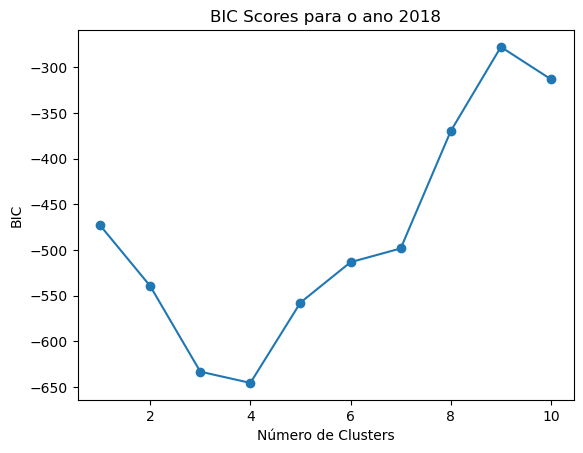

Processando o ano: 2019
Ano 2019: Melhor número de clusters = 4


Processando o ano: 2020
Ano 2020: Melhor número de clusters = 3


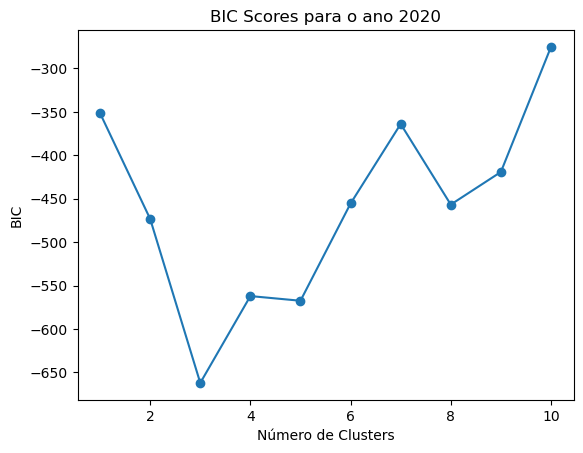

Processando o ano: 2021
Ano 2021: Melhor número de clusters = 6


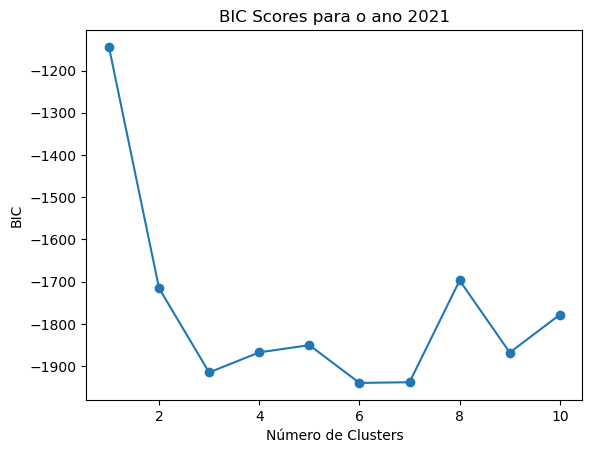

Processando o ano: 2023
Ano 2023: Melhor número de clusters = 5


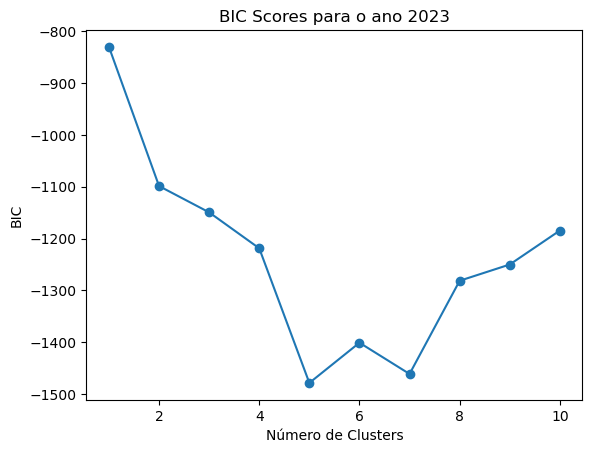

Processando o ano: 2024
Ano 2024: Melhor número de clusters = 5


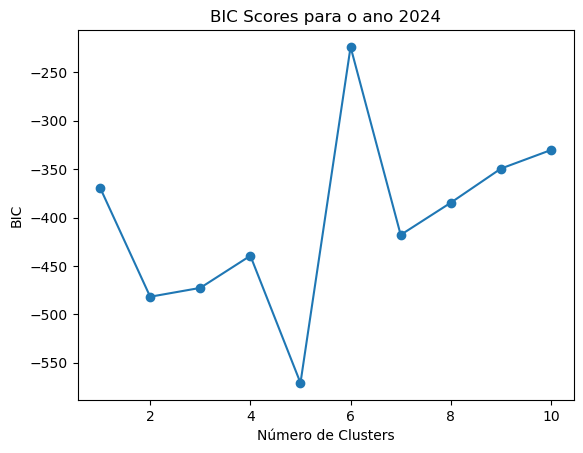

Processando o ano: 2022
Ano 2022: Melhor número de clusters = 5


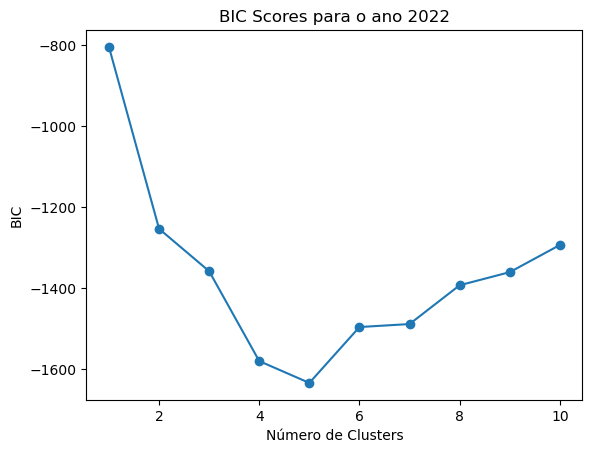

In [25]:
# Iterar pelos anos únicos
for year in df['ano'].unique():
    print(f"Processando o ano: {year}")
    
    # Filtrar o dataset para o ano atual
    df_year = df[df['ano'] == year]
    
    # Selecionar as features relevantes para o clustering
    features = ['media_preco', 'minimo_preco', 'maximo_preco', 'desvio_padrao_preco', 
                'media_dolar', 'media_preco_ajustador', 'amplitude_preco']
    
    # Verificar se o ano tem dados suficientes
    if df_year.shape[0] < 2:
        print(f"Ano {year} possui poucos dados. Ignorando...")
        continue
    
    # Escalonar os dados
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_year[features])
    
    # Testar diferentes números de clusters (de 1 a 10)
    bic_scores = []
    gmm_models = []
    for n_clusters in range(1, 11):
        gmm = GaussianMixture(n_components=n_clusters, random_state=42, covariance_type='full')
        gmm.fit(X_scaled)
        bic_scores.append(gmm.bic(X_scaled))
        gmm_models.append(gmm)
    
    # Identificar o melhor número de clusters com base no menor BIC
    best_n_clusters = np.argmin(bic_scores) + 1
    best_gmm = gmm_models[best_n_clusters - 1]  # Modelo correspondente ao melhor BIC
    
    # Re-treinar o modelo no melhor número de clusters
    labels = best_gmm.predict(X_scaled)
    
    # Adicionar os resultados ao DataFrame do ano atual
    df_year['cluster'] = labels
    df_year['ano_clusters'] = best_n_clusters

    # **Cálculo da log-verossimilhança para detectar outliers**
    log_likelihood = best_gmm.score_samples(X_scaled)  # Calcula a log-verossimilhança
    df_year['log_likelihood'] = log_likelihood

    # **Definir o limiar para anomalias (exemplo: percentil 5%)**
    threshold = np.percentile(log_likelihood, 5)  # Considera os 5% menores valores como outliers
    df_year['is_outlier'] = df_year['log_likelihood'] < threshold
    
    # Salvar os resultados para análise posterior
    results.append(df_year)
    
    # Exibir o resultado do ano atual
    print(f"Ano {year}: Melhor número de clusters = {best_n_clusters}")
    
    # Plotar o BIC para visualização
    plt.figure()
    plt.plot(range(1, 11), bic_scores, marker='o')
    plt.title(f"BIC Scores para o ano {year}")
    plt.xlabel('Número de Clusters')
    plt.ylabel('BIC')
    plt.savefig(f'bic_scores_{year}.png')  # Salva o gráfico no formato PNG
    plt.show()

#### Concatenando os clusters ao dataset geral

In [26]:
# Concatenar todos os resultados em um único DataFrame
df_final = pd.concat(results, ignore_index=True)
df_final

cnpj  latitude  longitude                      bandeira  \
0      00.192.116/0001-70 -3.757513 -38.534735  PETROBRAS DISTRIBUIDORA S.A.   
1      00.327.248/0001-61 -3.739645 -38.491485                        BRANCA   
2      00.327.248/0001-61 -3.739645 -38.491485                      IPIRANGA   
3      00.333.717/0001-55 -3.731656 -38.548329                        RAIZEN   
4      00.339.611/0001-69 -3.754470 -38.535884  PETROBRAS DISTRIBUIDORA S.A.   
...                   ...       ...        ...                           ...   
1197   41.311.770/0001-32 -3.786440 -38.551624                        RAIZEN   
1198   63.553.168/0001-44 -3.757501 -38.586932                        BRANCA   
1199   69.373.793/0001-90 -3.770139 -38.606937                 VIBRA ENERGIA   
1200   73.346.801/0001-87 -3.806818 -38.563338                 VIBRA ENERGIA   
1201   86.870.680/0001-10 -3.764650 -38.512675                      IPIRANGA   

       ano  media_preco  minimo_preco  maximo_preco  desvio_padrao_preco  \
0     2016     3.918214         3.830         3.999             0.061105   
1     2016     3.793000         3.690         3.990             0.170666   
2     2016     3.908833         3.699         3.989             0.088435   
3     2016     3.887071         3.690         3.990             0.097152   
4     2016     3.911857         3.819         3.990             0.063812   
...    ...          ...           ...           ...                  ...   
1197  2022     6.577778         4.870         7.790             0.845645   
1198  2022     6.655526         4.980         7.690             0.830453   
1199  2022     6.834800         5.270         7.980             0.889289   
1200  2022     6.555946         4.750         7.890             0.897229   
1201  2022     4.790000         4.790         4.790             0.000000   

      media_dolar  media_preco_ajustador  minimo_preco_ajustado  \
0        3.481493               1.131201               0.960399   
1        3.354733               1.131769               1.085642   
2        3.523225               1.118089               0.958561   
3        3.477550               1.123565               0.955461   
4        3.479736               1.130004               0.960399   
...           ...                    ...                    ...   
1197     5.139947               1.285801               0.946311   
1198     5.137719               1.301227               0.943004   
1199     5.098314               1.347075               1.028835   
1200     5.123951               1.286293               0.922993   
1201     5.146300               0.930766               0.930766   

      maximo_preco_ajustado  amplitude_preco  cluster  ano_clusters  \
0                  1.222040            0.169        2             5   
1                  1.220333            0.300        0             5   
2                  1.249686            0.290        2             5   
3                  1.228624            0.300        2             5   
4                  1.234877            0.171        2             5   
...                     ...              ...      ...           ...   
1197               1.583376            2.920        1             5   
1198               1.586790            2.710        1             5   
1199               1.629735            2.710        1             5   
1200               1.606210            3.140        1             5   
1201               0.930766            0.000        0             5   

      log_likelihood  is_outlier  
0           4.874565       False  
1          -1.167311        True  
2           3.032811       False  
3           5.673490       False  
4           5.415732       False  
...              ...         ...  
1197       11.481500       False  
1198       10.530946       False  
1199        8.818729       False  
1200       11.028077       False  
1201        9.170923       False  

[1202 rows x 18 columns]

### Análise outliers 2024

In [48]:
outliers_2024 = df_final[(df_final['cluster'] == 3) & (df_final['ano'] == 2024)]
outliers_2024 = outliers_2024[['cnpj', 'media_preco', 'minimo_preco', 'maximo_preco', 'desvio_padrao_preco', 'media_dolar', 'media_preco_ajustador', 'amplitude_preco', 'log_likelihood', 'is_outlier']]
outliers_2024.sort_values(by = 'is_outlier', ascending = False, inplace = True)
outliers_2024

cnpj  media_preco  minimo_preco  maximo_preco  \
967    02.782.524/0001-07     5.987500          5.66          6.25   
1019   07.295.702/0001-99     5.905000          5.69          6.12   
1025   07.861.314/0001-28     5.856667          5.67          5.97   
1055   11.535.248/0001-73     5.850000          5.45          6.27   
978    04.196.165/0001-31     5.900000          5.69          6.25   
1009   07.240.450/0008-77     5.960000          5.86          6.16   
1016   07.240.641/0034-20     5.788333          5.69          6.08   
1017   07.240.641/0037-73     6.004286          5.69          6.59   
1018   07.240.641/0039-35     6.000000          5.67          6.39   
1024   07.857.332/0001-36     5.838571          5.45          6.39   
1031   08.509.223/0001-90     5.790000          5.67          6.15   
1015   07.240.641/0032-69     5.881429          5.59          6.39   
996    05.815.683/0002-30     5.722000          5.45          5.99   
999    05.916.454/0001-20     5.891429          5.49          6.17   
1010   07.240.641/0003-24     5.749091          5.45          6.19   
986    04.961.676/0001-00     5.690000          5.59          5.79   
1051   10.658.840/0001-08     5.910000          5.59          6.35   
1044   09.618.519/0001-02     5.660000          5.53          5.79   
1057   12.255.543/0001-39     5.892857          5.59          5.99   
1072   41.311.770/0001-32     5.780000          5.63          5.93   
1065   17.599.872/0001-10     5.790000          5.69          5.99   
1063   16.526.400/0001-75     5.880000          5.79          5.97   
1061   13.468.543/0001-80     5.865000          5.59          5.99   
960    02.486.455/0001-94     5.734348          5.37          6.01   
991    05.331.201/0001-95     5.878333          5.66          6.09   
1056   11.587.746/0001-60     5.976667          5.86          6.19   

      desvio_padrao_preco  media_dolar  media_preco_ajustador  \
967              0.176938     5.158820               1.163773   
1019             0.304056     5.081300               1.163429   
1025             0.162891     5.632633               1.039700   
1055             0.391663     5.375520               1.089539   
978              0.234521     5.406686               1.094465   
1009             0.173205     5.592333               1.065654   
1016             0.163758     5.063583               1.143765   
1017             0.343650     5.164857               1.165722   
1018             0.301397     5.198183               1.158451   
1024             0.331181     5.306643               1.104308   
1031             0.240000     5.111325               1.133680   
1015             0.346767     5.207243               1.132557   
996              0.198427     5.270500               1.086991   
999              0.251425     4.964629               1.187346   
1010             0.316495     5.327636               1.080880   
986              0.141421     5.310100               1.071780   
1051             0.296917     5.216183               1.138064   
1044             0.183848     5.157750               1.098676   
1057             0.143958     4.951820               1.190945   
1072             0.212132     4.906071               1.177953   
1065             0.173205     5.370567               1.079561   
1063             0.127279     4.941200               1.190706   
1061             0.189297     5.427975               1.084143   
960              0.222850     5.314491               1.082632   
991              0.181705     4.989950               1.178492   
1056             0.185023     4.989000               1.198106   

      amplitude_preco  log_likelihood  is_outlier  
967              0.59        1.082362        True  
1019             0.43        1.059699        True  
1025             0.30        0.714642        True  
1055             0.82        0.612761        True  
978              0.56        4.900608       False  
1009             0.30        1.162591       False  
1016      

- Analisando o ano de 2024 o cluster 3 contém 26 postos dos quais 4 foram considerados outliers pelo critério do log da verossimilhança. dando um foco maior a cada um, percebemos localidades diferentes para o preço do posto indicando um possível dado anômalo.

### Mapa de Preços em Fortaleza com Folium
#### HeatMap somente para ilustrar a média de preços em um ano fixo escolhido manualmente

In [28]:
# Filtrar dados de um ano específico
year = 2022  # Altere para o ano desejado
df_year = df_final[df_final['ano'] == year]

In [29]:
import folium
from folium.plugins import HeatMap
import pandas as pd

# Supondo que df_year seja o seu DataFrame com as colunas 'latitude', 'longitude' e 'media_preco'
# Criar um mapa centralizado em Fortaleza
fortaleza_map = folium.Map(location=[-3.71722, -38.5434], zoom_start=12)

# Garantir que os dados de latitudes e longitudes sejam numéricos
heat_data = []

# Iterar sobre o DataFrame para adicionar dados válidos à lista heat_data
for _, row in df_year.iterrows():
    latitude = row['latitude']
    longitude = row['longitude']
    price = row['media_preco']
    
    # Verificar se latitude, longitude e preço são válidos
    if pd.to_numeric(latitude, errors='coerce') is not None and pd.to_numeric(longitude, errors='coerce') is not None and pd.to_numeric(price, errors='coerce') is not None:
        heat_data.append([latitude, longitude, price])

# Garantir que 'heat_data' seja uma lista de listas com dados válidos
print(heat_data[:5])  # Verifique os primeiros registros para depuração

# Obter o maior e menor preço para configurar a escala de cores
max_price = df_year['media_preco'].max()
min_price = df_year['media_preco'].min()

# Definir a escala de cores de azul para vermelho
# Convertendo valores de gradiente para strings para evitar erro
gradient = {
    "0.0": 'blue',         # menor preço (azul)
    "0.2": 'cyan',         # preços baixos
    "0.4": 'green',        # preços intermediários
    "0.6": 'yellow',       # preços mais altos
    "0.8": 'orange',       # preços muito altos
    "1.0": 'red'           # maior preço (vermelho)
}

# Adicionar HeatMap com a escala de cores personalizada
HeatMap(heat_data, radius=10, max_zoom=13, gradient=gradient).add_to(fortaleza_map)

# Salvar ou exibir o mapa
fortaleza_map.save("heatmap_fortaleza_custom_gradient.html")
fortaleza_map


[[-3.7575135, -38.5347351, 5.615], [-3.7396454, -38.4914847, 4.989999999999999], [-3.7316558, -38.548329, 4.93076923076923], [-3.7544696, -38.5358842, 5.585], [-3.8289091, -38.5271186, 7.486]]


### Salvar todos os anos em mapas distisntos
#### Criando heatmaps para todos os anos

In [30]:
import folium
from folium.plugins import HeatMap
import pandas as pd

# Supondo que df_final seja seu DataFrame com as colunas 'latitude', 'longitude', 'media_preco' e 'ano'

# Obter lista única de anos no DataFrame
anos = df_final['ano'].unique()

# Iterar sobre cada ano e gerar o mapa correspondente
for year in anos:
    # Filtrar dados para o ano atual
    df_year = df_final[df_final['ano'] == year]
    
    # Criar um mapa centralizado em Fortaleza
    fortaleza_map = folium.Map(location=[-3.71722, -38.5434], zoom_start=12)

    # Garantir que os dados de latitudes e longitudes sejam numéricos
    heat_data = []

    # Iterar sobre o DataFrame para adicionar dados válidos à lista heat_data
    for _, row in df_year.iterrows():
        latitude = row['latitude']
        longitude = row['longitude']
        price = row['media_preco']
        
        # Verificar se latitude, longitude e preço são válidos
        if pd.to_numeric(latitude, errors='coerce') is not None and pd.to_numeric(longitude, errors='coerce') is not None and pd.to_numeric(price, errors='coerce') is not None:
            heat_data.append([latitude, longitude, price])

    # Garantir que 'heat_data' seja uma lista de listas com dados válidos
    print(f"Dados para o ano {year}: {len(heat_data)} pontos de dados")

    # Obter o maior e menor preço para configurar a escala de cores
    max_price = df_year['media_preco'].max()
    min_price = df_year['media_preco'].min()

    # Definir a escala de cores de azul para vermelho
    gradient = {
        "0.0": 'blue',         # menor preço (azul)
        "0.2": 'cyan',         # preços baixos
        "0.4": 'green',        # preços intermediários
        "0.6": 'yellow',       # preços mais altos
        "0.8": 'orange',       # preços muito altos
        "1.0": 'red'           # maior preço (vermelho)
    }

    # Adicionar HeatMap com a escala de cores personalizada
    HeatMap(heat_data, radius=10, max_zoom=13, gradient=gradient).add_to(fortaleza_map)

    # Salvar o mapa em um arquivo HTML com o nome do ano
    fortaleza_map.save(f"heatmap_fortaleza_{year}_custom_gradient.html")
    print(f"Mapa do ano {year} salvo como 'heatmap_fortaleza_{year}_custom_gradient.html'")


Dados para o ano 2016: 130 pontos de dados
Mapa do ano 2016 salvo como 'heatmap_fortaleza_2016_custom_gradient.html'
Dados para o ano 2017: 129 pontos de dados
Mapa do ano 2017 salvo como 'heatmap_fortaleza_2017_custom_gradient.html'
Dados para o ano 2018: 123 pontos de dados
Mapa do ano 2018 salvo como 'heatmap_fortaleza_2018_custom_gradient.html'
Dados para o ano 2019: 122 pontos de dados
Mapa do ano 2019 salvo como 'heatmap_fortaleza_2019_custom_gradient.html'
Dados para o ano 2020: 124 pontos de dados
Mapa do ano 2020 salvo como 'heatmap_fortaleza_2020_custom_gradient.html'
Dados para o ano 2021: 159 pontos de dados
Mapa do ano 2021 salvo como 'heatmap_fortaleza_2021_custom_gradient.html'
Dados para o ano 2023: 164 pontos de dados
Mapa do ano 2023 salvo como 'heatmap_fortaleza_2023_custom_gradient.html'
Dados para o ano 2024: 126 pontos de dados
Mapa do ano 2024 salvo como 'heatmap_fortaleza_2024_custom_gradient.html'
Dados para o ano 2022: 125 pontos de dados
Mapa do ano 2022 salv

### Animação do preço médio da gasolina em fortaleza ao longo do tempo

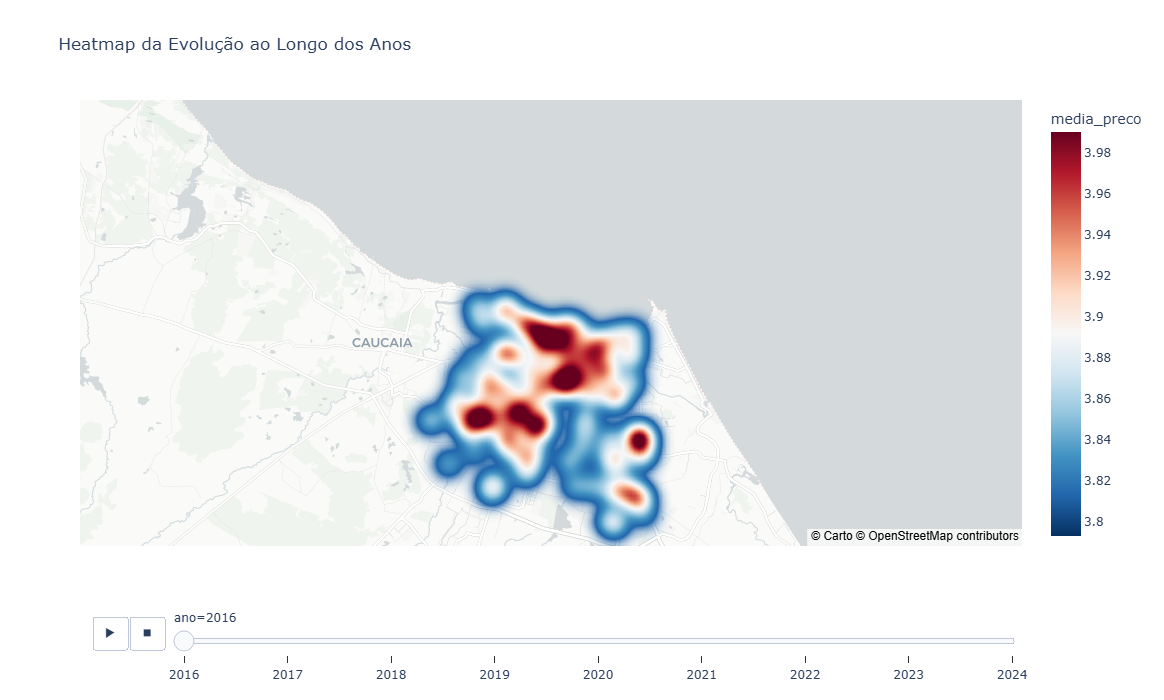

In [84]:
import plotly.express as px
import pandas as pd

# Exemplo de DataFrame (substitua com seu próprio DataFrame)
# df_final deve conter as colunas: 'latitude', 'longitude', 'media_preco', 'ano'
# Aqui, 'df_final' é um DataFrame com dados de latitudes, longitudes e preços médios

# Garantir que os anos estejam na ordem correta
df_final['ano'] = df_final['ano'].astype(int)  # Certificando-se de que 'ano' seja do tipo inteiro
df_final = df_final.sort_values('ano') 


# Criar a animação com plotly.express
fig = px.density_mapbox(df_final, 
                        lat="latitude", 
                        lon="longitude", 
                        z="media_preco", 
                        animation_frame="ano", 
                        #color_continuous_scale="Viridis",  # Escala de cores
                        color_continuous_scale="RdBu_r",
                        title="Heatmap da Evolução ao Longo dos Anos",
                        mapbox_style="carto-positron",  # Estilo do mapa
                        center={"lat": -3.71722, "lon": -38.5434},  # Centralizar em Fortaleza
                        zoom=10)

# Ajustando o tamanho do gráfico
fig.update_layout(
    mapbox_accesstoken="your_mapbox_token",  # Se necessário, insira seu token do Mapbox
    width=900,  # Largura do gráfico
    height=700,  # Altura do gráfico
)

# Salvar a animação como um arquivo HTML
fig.write_html("heatmap_evolucao_anos.html")

# Exibir a animação
fig.show()

### Mapa Interativo com Clusters

In [32]:
# Agrupar por ano e contar o número de clusters únicos
clusters_por_ano = df_final.groupby('ano')['cluster'].nunique().reset_index()

# Renomear a coluna para algo mais intuitivo
clusters_por_ano.columns = ['Ano', 'Número de Clusters']

# Exibir o resultado
clusters_por_ano

Ano  Número de Clusters
0  2016                   5
1  2017                   2
2  2018                   4
3  2019                   4
4  2020                   3
5  2021                   6
6  2022                   5
7  2023                   5
8  2024                   5

### Identificando Outliers

In [33]:
import folium
from folium import LayerControl
from IPython.display import IFrame
import pandas as pd


# Mapear clusters para cores
cluster_colors = {
    0: 'blue',
    1: 'green',
    2: 'red',
    3: 'orange',
    4: 'purple',
    5: 'yellow',
    6: 'cyan'  # Adicionando uma cor para o cluster 6
}

# Função para gerar o mapa interativo com destaque para outliers
def gerar_mapa_interativo(df):
    # Criar o mapa centralizado em Fortaleza
    fortaleza_map = folium.Map(location=[-3.71722, -38.5434], zoom_start=12)

    # Criar um dicionário para armazenar as camadas de clusters por ano
    anos = df['ano'].unique()  # Obter lista de anos únicos
    year_groups = {}

    for ano in anos:
        # Criar um grupo de camadas para cada ano
        year_group = folium.FeatureGroup(name=str(ano))

        # Filtrar dados para o ano específico
        df_ano = df[df['ano'] == ano]

        # Adicionar marcadores para cada cluster do ano
        for _, row in df_ano.iterrows():
            latitude = row['latitude']
            longitude = row['longitude']
            cluster = row['cluster']
            is_outlier = row['is_outlier']  # Indica se é outlier

            # Definir a cor do marcador com base no cluster
            cor = cluster_colors.get(cluster, 'gray')  # Usar cinza caso o cluster não tenha cor definida
            
            if is_outlier:  # Se for um outlier, usar um ícone de estrela com a cor do cluster
                folium.Marker(
                    location=[latitude, longitude],
                    icon=folium.Icon(icon="star", color=cor),  # Ícone de estrela com a cor do cluster
                    popup=f"Cluster: {cluster}, Ano: {ano} (Outlier)"
                ).add_to(year_group)
            else:  # Se não for outlier, usar um círculo normal
                folium.CircleMarker(
                    location=[latitude, longitude],
                    radius=5,  # Tamanho do ponto
                    color=cor,
                    fill=True,
                    fill_color=cor,
                    fill_opacity=0.6,
                    popup=f"Cluster: {cluster}, Ano: {ano}"
                ).add_to(year_group)

        # Adicionar o grupo de camadas ao mapa
        year_groups[ano] = year_group
        year_group.add_to(fortaleza_map)

    # Adicionar o controle de camadas ao mapa para permitir a filtragem por ano
    LayerControl(collapsed=False).add_to(fortaleza_map)

    # Salvar o mapa interativo em um arquivo HTML
    mapa_path = "mapa_clusters_interativo.html"
    fortaleza_map.save(mapa_path)
    print(f"Mapa interativo gerado e salvo como {mapa_path}")

    # Exibir o mapa diretamente no notebook
    return IFrame(mapa_path, width=800, height=600)

# Gerar e exibir o mapa interativo
gerar_mapa_interativo(df_final)


Mapa interativo gerado e salvo como mapa_clusters_interativo.html


### Estatísticas dos Outliers por Média de Preço
#### Distribuição das Médias de Preço de dados anômalos (Outiliers) por Cluster e Ano

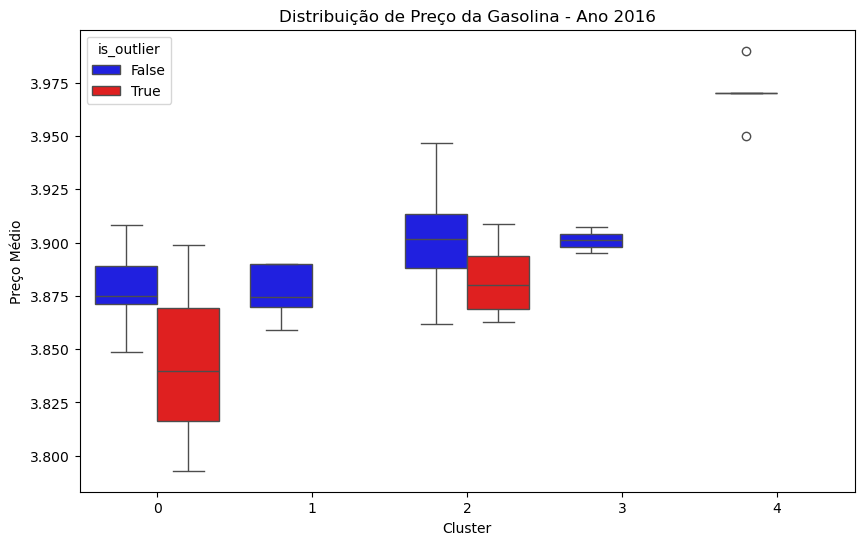

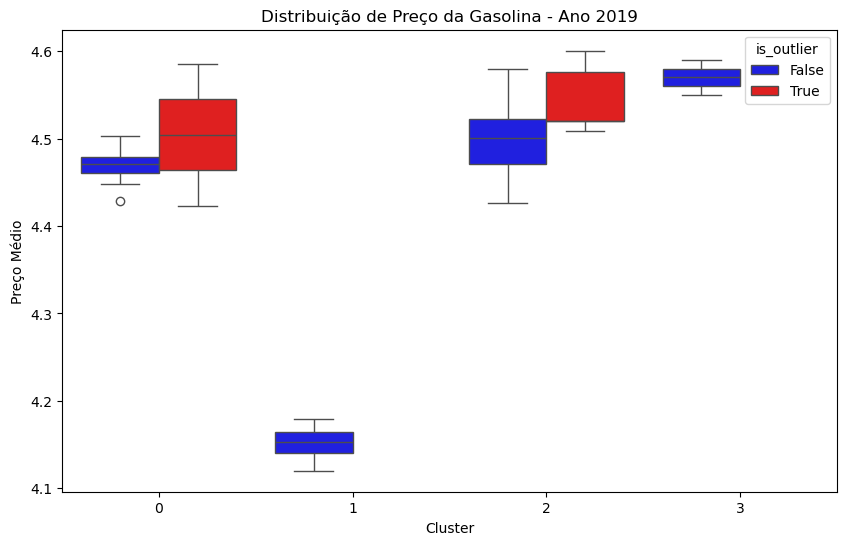

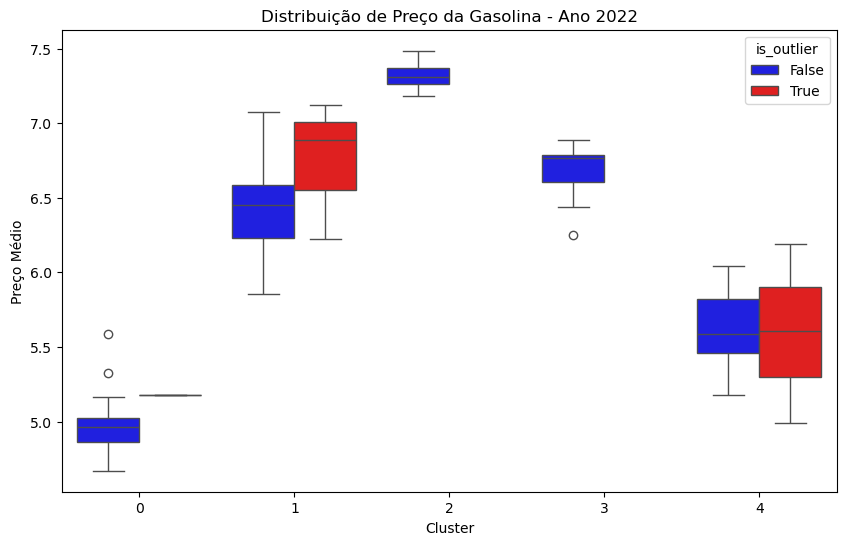

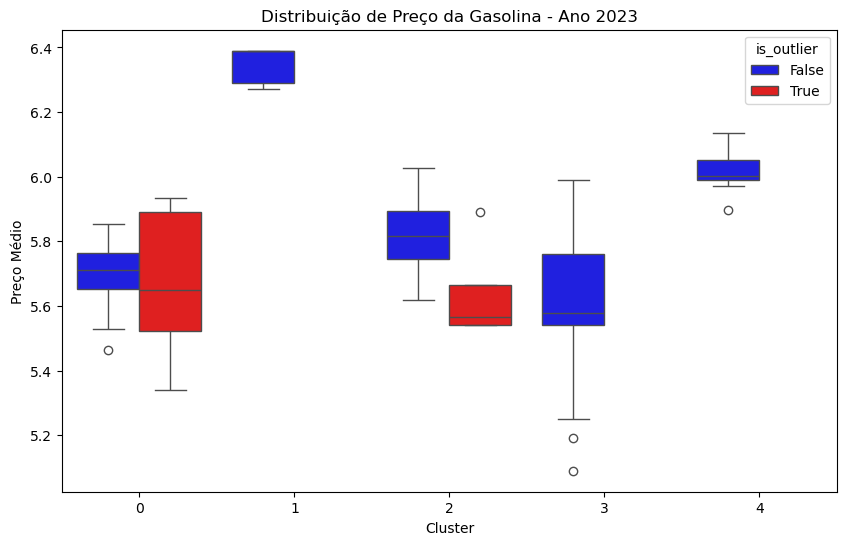

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Iterando sobre os anos únicos no dataset e gerando um gráfico separado para cada um
for ano in df_final['ano'].unique():
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_final[df_final['ano'] == ano], x='cluster', y='media_preco', hue='is_outlier', palette={False: 'blue', True: 'red'}, showfliers=True)
    plt.title(f'Distribuição de Preço da Gasolina - Ano {ano}')
    plt.xlabel('Cluster')
    plt.ylabel('Preço Médio')
    # Salvando o gráfico em um arquivo
    plt.savefig(f'Distribuição de Preço da Gasolina - Ano {ano}.png', dpi=300, bbox_inches='tight')  # Salva o gráfico com nome baseado no ano
    #plt.close()  # Fecha a figura atual para liberar memória e evitar sobrecarga
    plt.show()


### Outra Visualização - Sino

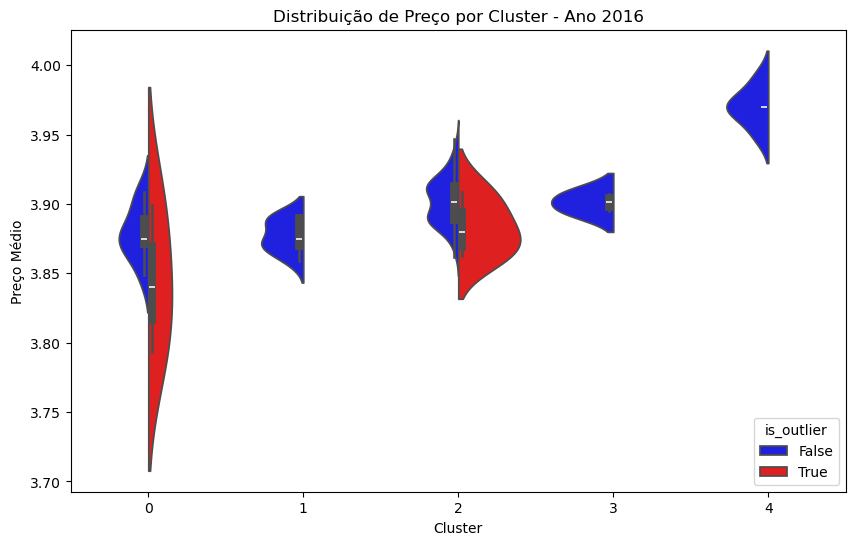

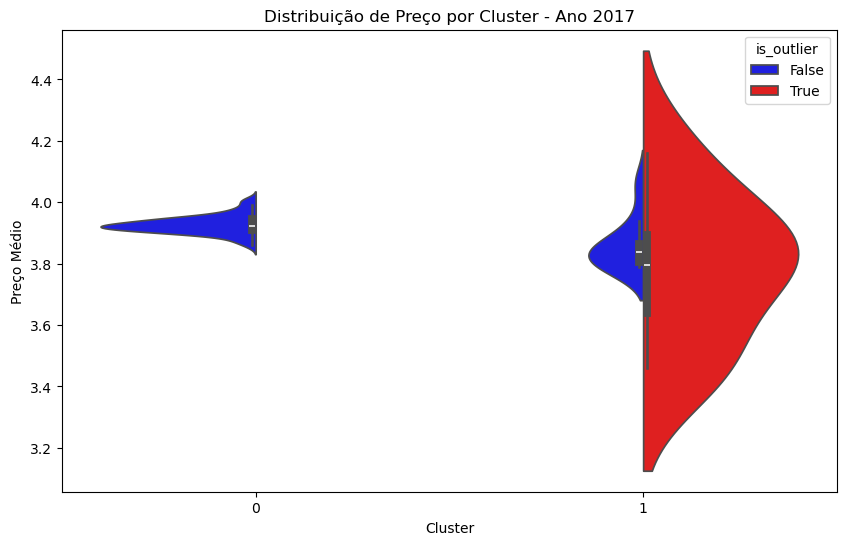

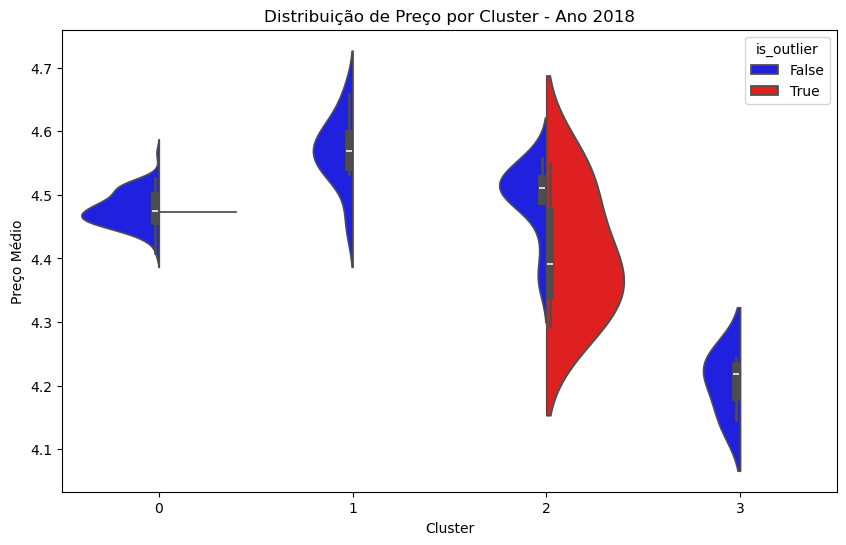

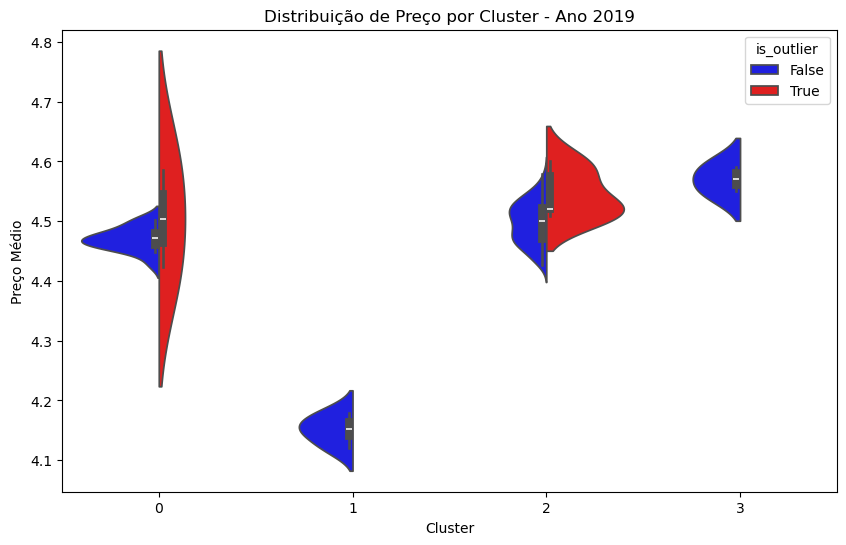

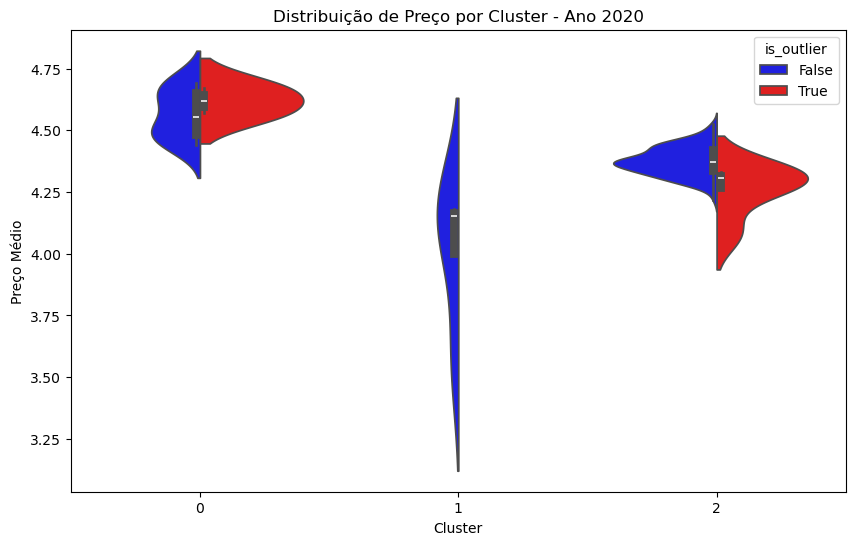

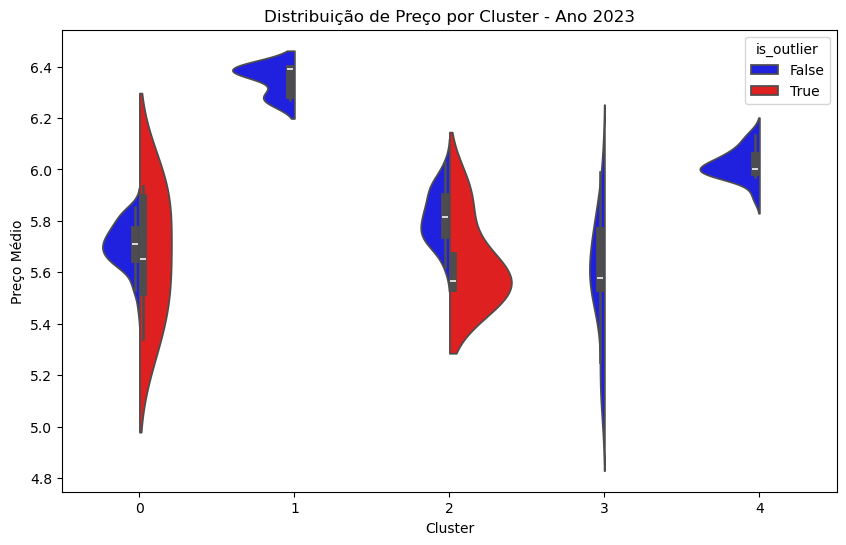

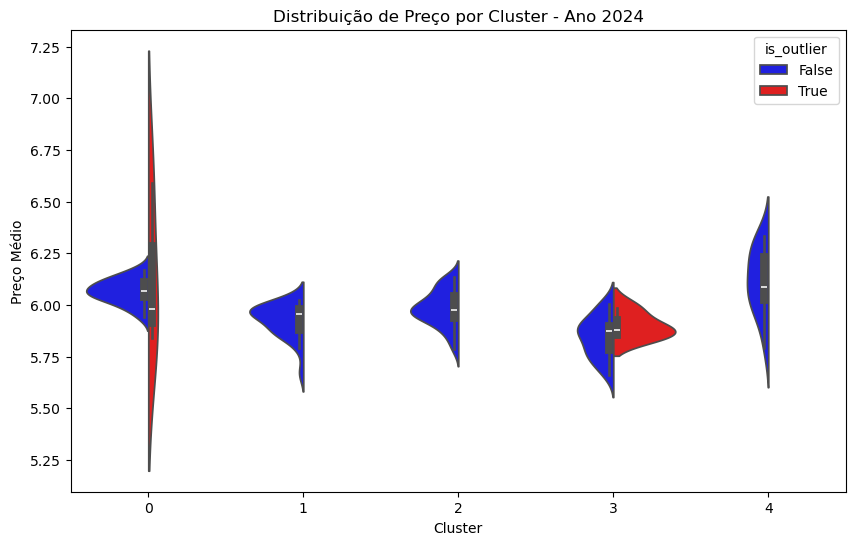

In [35]:
for ano in df_final['ano'].unique():
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=df_final[df_final['ano'] == ano], x='cluster', y='media_preco', hue='is_outlier', split=True, palette={False: 'blue', True: 'red'})
    plt.title(f'Distribuição de Preço por Cluster - Ano {ano}')
    plt.xlabel('Cluster')
    plt.ylabel('Preço Médio')
    plt.show()


## Regressão Linear Bayesiana e Processos Gaussianos

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.linear_model import BayesianRidge
from skopt import BayesSearchCV
from bayes_opt import BayesianOptimization
import time

### Função de Avaliação do Modelo

In [59]:
# Avaliação dos modelos
def avaliar_modelo(y_real, y_pred, nome_modelo):
    mse = mean_squared_error(y_real, y_pred)
    rmse = sqrt(mse)
    mae = mean_absolute_error(y_real, y_pred)
    print(f"📊 {nome_modelo} - MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")

In [60]:
df_preco4 = df_filtrado.copy()
df_preco4 = df_preco4[["cnpj", "latitude", "longitude", "dolar", "preco", "data" ]]
df_preco4.head(3)

cnpj  latitude  longitude   dolar  preco       data
1    07.304.199/0003-52 -3.813689 -38.613696  4.0269   3.89 2016-01-06
7    07.857.332/0001-36 -3.752016 -38.512243  4.0373   3.88 2016-01-05
12   06.352.771/0001-24 -3.757896 -38.522169  4.0373   3.89 2016-01-05

### Separação de Treino e Teste levando em consideração a ordem Temporal
- Para efeitos de Modelagem o Treino vai de "2021-01-01" a "2024-09-30" e o teste a partir de "2024-09-30" até "2024-12-27"

In [61]:
# 1. Ordenar os dados pela coluna de 'data' e dividir em treino e teste
df_preco4 = df_preco4.sort_values(by='data')

# Definir as datas
data_inicio_treino = "2021-01-01"
data_limite = "2024-09-30"

# Criar os conjuntos de treino e teste
df_train = df_preco4[(df_preco4['data'] >= data_inicio_treino) & (df_preco4['data'] <= data_limite)]
df_test = df_preco4[df_preco4['data'] > data_limite]

In [62]:
# 2. Criar a feature 'dias_desde_inicio' com a diferença de dias desde o primeiro dia
df_train['dias_desde_inicio'] = (df_train['data'] - df_train['data'].min()).dt.days
df_test['dias_desde_inicio'] = (df_test['data'] - df_test['data'].min()).dt.days

# 🔹 Criar features temporais
df_train['mes'] = df_train['data'].dt.month
df_train['dia_da_semana'] = df_train['data'].dt.weekday
df_test['mes'] = df_test['data'].dt.month
df_test['dia_da_semana'] = df_test['data'].dt.weekday

In [63]:
# 3. Criar médias móveis e variáveis de agregação apenas no treino
# Médias móveis de 7 dias e 30 dias (baseado nos dados de treino)
df_train['preco_medio_posto_7d'] = (df_train.groupby('cnpj')['preco'].shift(1).rolling(7, min_periods=1).mean().bfill())
df_train['preco_medio_posto_14d'] = (df_train.groupby('cnpj')['preco'].shift(1).rolling(14, min_periods=1).mean().bfill())
df_train['preco_medio_posto_30d'] = (df_train.groupby('cnpj')['preco'].shift(1).rolling(30, min_periods=1).mean().bfill())
df_train['preco_medio_posto_60d'] = (df_train.groupby('cnpj')['preco'].shift(1).rolling(60, min_periods=1).mean().bfill())
df_train['delta_preco_posto_7d'] = df_train['preco_medio_posto_7d'] - df_train['preco_medio_posto_30d']



In [64]:
# 4. Aplicar as mesmas transformações nos dados de df_teste
# Médias móveis e variáveis de agregação nos dados de df_teste
df_test['preco_medio_posto_7d'] = (df_test.groupby('cnpj')['preco'].shift(1).rolling(7, min_periods=1).mean().bfill())
df_test['preco_medio_posto_14d'] = (df_test.groupby('cnpj')['preco'].shift(1).rolling(14, min_periods=1).mean().bfill())
df_test['preco_medio_posto_30d'] = (df_test.groupby('cnpj')['preco'].shift(1).rolling(30, min_periods=1).mean().bfill())
df_test['preco_medio_posto_60d'] = (df_test.groupby('cnpj')['preco'].shift(1).rolling(60, min_periods=1).mean().bfill())

df_test['delta_preco_posto_7d'] = df_test['preco_medio_posto_7d'] - df_test['preco_medio_posto_30d']

### Explicação das Features Criadas

 - dias_desde_inicio. O fator temporal ajuda a capturar padrões temporais que podem influenciar o preço ao longo do tempo.
 - mes e dia_da_semana. Ajuda a analisar o comportamento dos preços quando existe sazonalidade no período semanal e mensal.
 - preco_medio_posto_7d, preco_medio_posto_14d, preco_medio_posto_30d, preco_medio_posto_60d, delta_preco_posto_7d. Janelas Móveis ajudam a suavizar flutuações diárias e identificar tendências.
 - cnpj_media_preco. O target encoding é útil para capturar o efeito do posto de forma agrupada ou agregada, postos podem ter uma distrubuição de preços significativamente diferentes, essa feature ajuda a representar o comportamento do preço dependendo do posto de combustível.

#### Selecionando as features

In [65]:
# Selecionar features e target
features = ['dias_desde_inicio', 'latitude', 'longitude', 'dolar', 'mes', 'dia_da_semana',
            'preco_medio_posto_7d', 'preco_medio_posto_14d', 'preco_medio_posto_30d', 'preco_medio_posto_60d', 'delta_preco_posto_7d']


In [66]:
X_train =  df_train[features]
y_train = df_train['preco']

X_test = df_test[features]
y_test = df_test['preco']

In [67]:
from sklearn.preprocessing import StandardScaler

# Normalização dos dados
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

#### Para o processo gaussiano utilizamos uma combinação de dois kernels, o constante e o RBF

- Escolhemos kernel constante (C) que define a variância global da função, e o kernel RBF que define a suavidade e a correlação entre pontos no espaço de entrada. Juntos, esses dois kernels especificam a forma da distribuição a priori da função que o modelo vai aprender.
- Esta combinação é útil por que captura tendência ao mesmo tempo que captura a complexidade não linear.

#### Regressão Linear Bayesiana com Intervalos de Confiança

In [68]:
ini = time.time()

# **Modelo 2: Regressão Linear Bayesiana**
model1 = BayesianRidge()
model1.fit(X_train_scaled, y_train_scaled)


y_pred_bayes_scaled, std_pred = model1.predict(X_test_scaled, return_std=True)


y_pred_bayes = scaler_y.inverse_transform(y_pred_bayes_scaled.reshape(-1, 1)).flatten()


# Definindo um intervalo de confiança (ex: 95%)
confidence_interval = 1.96  # Para um intervalo de confiança de 95%

# Calculando os intervalos superior e inferior sem reshape
y_pred_bayes_upper = y_pred_bayes + confidence_interval * std_pred
y_pred_bayes_lower = y_pred_bayes - confidence_interval * std_pred


avaliar_modelo(y_test, y_pred_bayes, "Regressão Linear Bayesiana")

# Evita divisão por zero substituindo valores muito pequenos de std_pred
std_pred = np.maximum(std_pred, 1e-6)

# Calcula a NLPD
nlpd = -np.mean(-0.5 * ((y_test - y_pred_bayes) ** 2 / std_pred**2) - 0.5 * np.log(2 * np.pi * std_pred**2))

print(f"NLPD (Negative Log Predictive Density): {nlpd:.4f}")

fim = time.time()

print(int(fim - ini))

📊 Regressão Linear Bayesiana - MSE: 0.0450 | RMSE: 0.2122 | MAE: 0.1503
NLPD (Negative Log Predictive Density): 0.1206
0


#### Regressão Linear Bayesiana otimizada com Intervalos de confiança

In [69]:
from scipy.stats import norm
# Função para otimização bayesiana dos hiperparâmetros da regressão bayesiana com NLPD
def bayesian_optimization(alpha_1, alpha_2):
    model3 = BayesianRidge(
        alpha_1=10**alpha_1, alpha_2=10**alpha_2
    )
    model3.fit(X_train_scaled, y_train_scaled)
    
    # Previsões e incerteza
    y_pred_scaled, std_pred = model3.predict(X_test_scaled, return_std=True)
    
    # Desnormalizar previsões e incerteza
    y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    std_pred_original = std_pred * scaler_y.scale_  # Ajustar desvio padrão para escala original
    
    # Evitar log de zero ou valores muito pequenos
    std_pred_original = np.maximum(std_pred_original, 1e-6)

    # Calcular NLPD
    nlpd = -np.mean(
        -0.5 * ((y_test - y_pred_original) ** 2) / (std_pred_original ** 2)
        - np.log(std_pred_original)
        - 0.5 * np.log(2 * np.pi)
    )
    
    return -nlpd  # Negativo porque a otimização maximiza a função objetivo

# Definir os limites de busca dos hiperparâmetros (log-space)
pbounds = {
    "alpha_1": (-12, -1),
    "alpha_2": (-12, -1)
}

# Otimização Bayesiana
optimizer = BayesianOptimization(
    f=bayesian_optimization,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)
optimizer.maximize(init_points=10, n_iter=25)

# Melhor conjunto de hiperparâmetros
best_params = optimizer.max['params']
best_params = {k: 10**v for k, v in best_params.items()}  # Converter de log-space

|   iter    |  target   |  alpha_1  |  alpha_2  |
-------------------------------------------------
| 1         | 0.03478   | -7.88     | -1.542    |
| 2         | 0.03479   | -3.948    | -5.415    |
| 3         | 0.03479   | -10.28    | -10.28    |
| 4         | 0.03479   | -11.36    | -2.472    |
| 5         | 0.03479   | -5.388    | -4.211    |
| 6         | 0.03477   | -11.77    | -1.331    |
| 7         | 0.03479   | -2.843    | -9.664    |
| 8         | 0.03479   | -10.0     | -9.983    |
| 9         | 0.03479   | -8.653    | -6.228    |
| 10        | 0.03479   | -7.249    | -8.796    |
| 11        | 0.03479   | -4.277    | -4.385    |
| 12        | 0.03479   | -11.04    | -3.618    |
| 13        | 0.03479   | -8.45     | -7.788    |
| 14        | 0.03479   | -7.105    | -6.985    |
| 15        | 0.03479   | -5.6      | -5.827    |
| 16        | 0.03479   | -7.139    | -5.167    |
| 17        | 0.03479   | -5.385    | -7.864    |
| 18        | 0.03479   | -3.521    | -7.982    |


In [70]:
best_params

{'alpha_1': 0.09998634702108383, 'alpha_2': 9.508434870026287e-07}

In [71]:
# 🔹 Treinar modelo final com os melhores hiperparâmetros
model4 = BayesianRidge(alpha_1=best_params['alpha_1'], alpha_2=best_params['alpha_2'])
model4.fit(X_train_scaled, y_train_scaled)

# 🔹 Fazer previsões
y_pred_scaled, std_pred = model4.predict(X_test_scaled, return_std=True)

# 🔹 Desnormalizar previsões
y_pred_opt = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
std_pred_opt = std_pred * scaler_y.scale_

# Definindo um intervalo de confiança (ex: 95%)
confidence_interval = 1.96  # Para um intervalo de confiança de 95%

# Calculando os intervalos superior e inferior sem reshape
y_pred_opt_upper = y_pred_opt + confidence_interval * std_pred_opt
y_pred_opt_lower = y_pred_opt - confidence_interval * std_pred_opt

# 🔹 Calcular NLPD final
nlpd_final = -np.mean(
    -0.5 * ((y_test - y_pred_opt) ** 2) / (std_pred_opt ** 2)
    - np.log(std_pred_opt)
    - 0.5 * np.log(2 * np.pi)
)

avaliar_modelo(y_test, y_pred_opt, "Regressão Linear Bayesiana Otimizada")
print(f"NLPD do melhor modelo: {nlpd_final:.4f}")

📊 Regressão Linear Bayesiana Otimizada - MSE: 0.0450 | RMSE: 0.2122 | MAE: 0.1503
NLPD do melhor modelo: -0.0348


### Processos Gaussianos

In [74]:
import torch
import gpytorch

In [75]:
X_train =  df_train[features]
y_train = df_train['preco']

X_test = df_test[features]
y_test = df_test['preco']

In [76]:
from sklearn.preprocessing import StandardScaler

# Normalização dos dados
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_train_norm = scaler_x.fit_transform(X_train)
X_test_norm = scaler_x.transform(X_test)
y_train_norm = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()


torch.manual_seed(42)
X_train_torch = torch.tensor(X_train_norm, dtype=torch.float32)
y_train_torch = torch.tensor(y_train_norm, dtype=torch.float32)
X_test_torch = torch.tensor(X_test_norm, dtype=torch.float32)

In [77]:
print(X_test_torch.shape) 

torch.Size([364, 11])


In [78]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        
        # Módulo de média (captura um valor médio para os dados)
        self.mean_module = gpytorch.means.ConstantMean()

        # Criando os kernels
        self.rbf_kernel = gpytorch.kernels.RBFKernel()  # Captura variações suaves
        self.linear_kernel = gpytorch.kernels.LinearKernel()  # Captura tendências lineares
        self.periodic_kernel = gpytorch.kernels.PeriodicKernel(period_length_prior=gpytorch.priors.SmoothedBoxPrior(30, 365))  # Captura sazonalidade (ciclo entre 30 e 365 dias)

        # Combinando os kernels: (Linear + Periódico + RBF)
        self.covar_module = gpytorch.kernels.ScaleKernel(self.linear_kernel + self.periodic_kernel + self.rbf_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [79]:
# Definir modelo e likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(X_train_torch, y_train_torch, likelihood)

# Colocar em modo de treinamento
model.train()
likelihood.train()

# Otimização dos hiperparâmetros
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Critério de perda (marginal log likelihood)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [80]:
ini = time.time()

for i in range(50):
    optimizer.zero_grad()
    output = model(X_train_torch)
    loss = -mll(output, y_train_torch)
    loss.backward()
    optimizer.step()
    if (i + 1) % 10 == 0:
        print(f'Iter {i+1}/50 - Loss: {loss.item():.3f}')


fim = time.time()
print(int(fim - ini))

Iter 10/50 - Loss: 1316.202
Iter 20/50 - Loss: 1311.309
Iter 30/50 - Loss: 1306.137
Iter 40/50 - Loss: 1300.654
Iter 50/50 - Loss: 1294.854
2716


In [81]:
ini = time.time()

# Colocar em modo de avaliação
model.eval()
likelihood.eval()

# Fazer predições
with torch.no_grad():
    preds = likelihood(model(X_test_torch))
    
    y_pred_norm = preds.mean.numpy()   # Média da predição
    y_pred_std = preds.stddev.numpy()  # Desvio padrão da predição

# Calcular intervalo de confiança de 95%
lower_norm = y_pred_norm - 1.96 * y_pred_std
upper_norm = y_pred_norm + 1.96 * y_pred_std


# Desnormalizar
y_pred_gp = scaler_y.inverse_transform(y_pred_norm.reshape(-1, 1)).ravel()
#y_test = scaler_y.inverse_transform(y_test.to_numpy().reshape(-1, 1)).ravel()
lower = scaler_y.inverse_transform(lower_norm.reshape(-1, 1)).ravel()
upper = scaler_y.inverse_transform(upper_norm.reshape(-1, 1)).ravel()


# Calcular RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_gp))
print(f'RMSE: {rmse:.4f}')

# Calcular NLPD (Negative Log Predictive Density)
log_density = -0.5 * np.log(2 * np.pi * y_pred_std**2) - 0.5 * ((y_test - y_pred_norm) ** 2 / (y_pred_std**2))

# NLPD é a soma negativa do log da densidade
nlpd = -np.sum(log_density)
print(f'NLPD: {nlpd:.4f}')

fim = time.time()
print(int(fim - ini))

RMSE: 0.3248
NLPD: 5125.9380
18


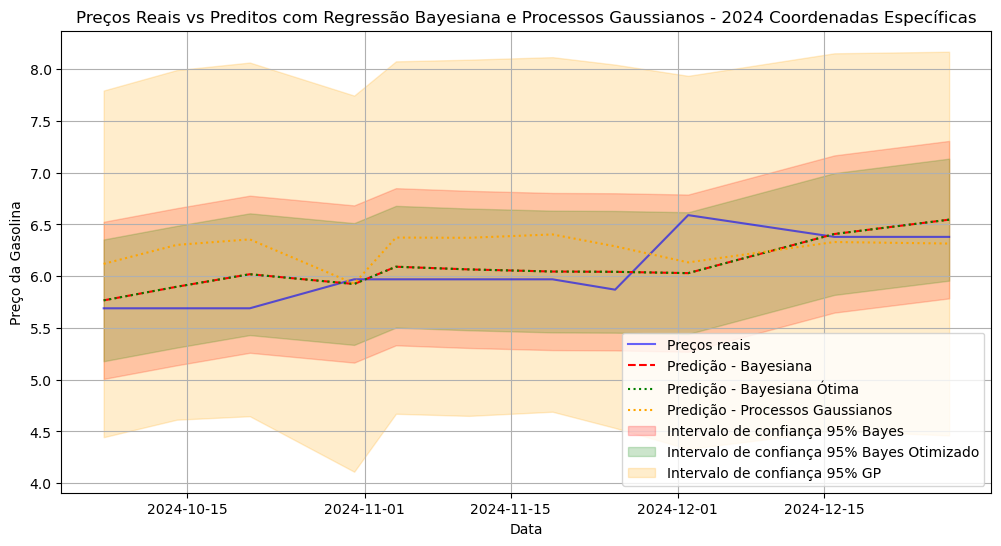

In [82]:
# 🔹 Ordenar os dados pelo tempo para visualização clara
test_data = X_test.copy()
test_data['data'] = df_preco4.loc[X_test.index, 'data']
test_data['preco_real'] = y_test
test_data['preco_predito_bayes'] = y_pred_bayes
test_data['preco_predito_bayes_upper'] = y_pred_bayes_upper
test_data['preco_predito_bayes_lower'] = y_pred_bayes_lower
test_data['preco_predito_bayes_opt'] = y_pred_opt
test_data['preco_predito_opt_upper'] = y_pred_opt_upper
test_data['preco_predito_opt_lower'] = y_pred_opt_lower
test_data['preco_predito_gp'] = y_pred_gp
test_data['preco_predito_gp_upper'] = upper
test_data['preco_predito_gp_lower'] = lower
test_data = test_data.sort_values('dias_desde_inicio')

# 🔹 Filtrar apenas os anos de 2024 e as coordenadas específicas
test_data = test_data[
    (test_data['data'].dt.year.isin([2024])) & 
    (test_data['latitude'] == -3.786213) & 
    (test_data['longitude'] == -38.6005159)
]


# 🔹 Plotando os resultados
plt.figure(figsize=(12, 6))

# Plot dos preços reais
plt.plot(test_data['data'], test_data['preco_real'], label="Preços reais", color='blue', alpha=0.6)

# Plot dos preços preditos - Reg. Bayesiana
plt.plot(test_data['data'], test_data['preco_predito_bayes'], label="Predição - Bayesiana", color='red', linestyle='--')

# Plot dos preços preditos - Reg. Bayesiana otimizada
plt.plot(test_data['data'], test_data['preco_predito_bayes_opt'], label="Predição - Bayesiana Ótima", color='green', linestyle='dotted')

# Plot dos preços preditos - Processo Gaussiano
plt.plot(test_data['data'], test_data['preco_predito_gp'], label="Predição - Processos Gaussianos", color='orange', linestyle=':')

# 🔹 Adicionar faixa de incerteza Bayes (Intervalos de Confiança 95%)
plt.fill_between(test_data['data'], 
                 test_data['preco_predito_bayes_lower'].to_numpy(), 
                 test_data['preco_predito_bayes_upper'].to_numpy(),
                 color='red', alpha=0.2, label="Intervalo de confiança 95% Bayes")

# 🔹 Adicionar faixa de incerteza Bayes Otimizada (Intervalos de Confiança 95%)
plt.fill_between(test_data['data'], 
                 test_data['preco_predito_opt_lower'].to_numpy(), 
                 test_data['preco_predito_opt_upper'].to_numpy(),
                 color='green', alpha=0.2, label="Intervalo de confiança 95% Bayes Otimizado")


# 🔹 Adicionar faixa de incerteza GP(Intervalos de Confiança 95%)
plt.fill_between(test_data['data'], 
                 test_data['preco_predito_gp_lower'].to_numpy(), 
                 test_data['preco_predito_gp_upper'].to_numpy(),
                 color='orange', alpha=0.2, label="Intervalo de confiança 95% GP")


# Ajustes do gráfico
plt.xlabel("Data")
plt.ylabel("Preço da Gasolina")
plt.title("Preços Reais vs Preditos com Regressão Bayesiana e Processos Gaussianos - 2024 Coordenadas Específicas")
plt.legend()
plt.grid(True)

# 🔹 **Salvar gráfico em PNG**
plt.savefig("precos_preditos_2024_coordenadas_específicas.png", dpi=300, bbox_inches="tight")


plt.show()

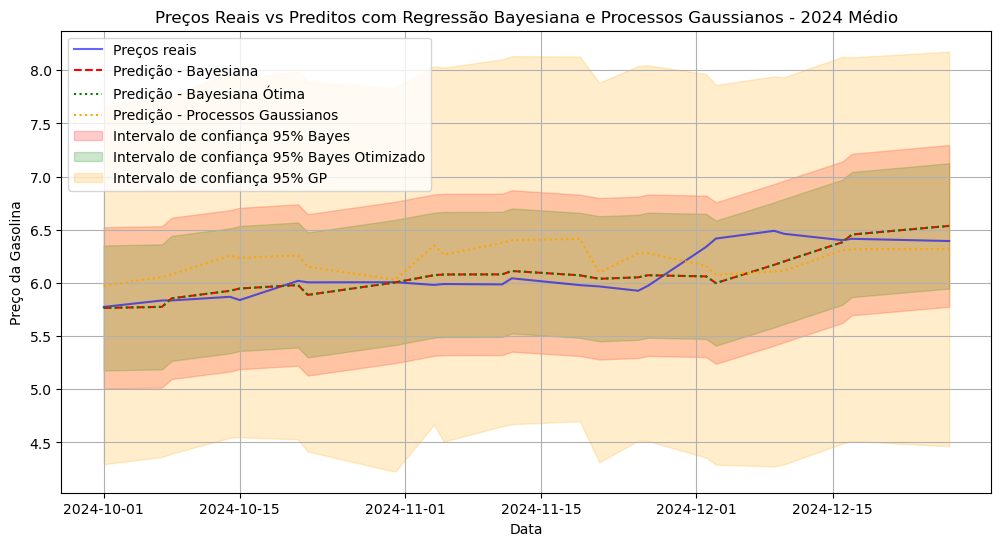

In [83]:
# 🔹 Ordenar os dados pelo tempo para visualização clara
test_data = X_test.copy()
test_data['data'] = df_preco4.loc[X_test.index, 'data']
test_data['preco_real'] = y_test
test_data['preco_predito_bayes'] = y_pred_bayes
test_data['preco_predito_bayes_upper'] = y_pred_bayes_upper
test_data['preco_predito_bayes_lower'] = y_pred_bayes_lower
test_data['preco_predito_bayes_opt'] = y_pred_opt
test_data['preco_predito_opt_upper'] = y_pred_opt_upper
test_data['preco_predito_opt_lower'] = y_pred_opt_lower
test_data['preco_predito_gp'] = y_pred_gp
test_data['preco_predito_gp_upper'] = upper
test_data['preco_predito_gp_lower'] = lower

# 🔹 Agrupar por data e calcular a média dos preços reais e preditos
test_data_grouped = test_data.groupby('data').agg({
    'preco_real': 'mean',
    'preco_predito_bayes': 'mean',
    'preco_predito_bayes_opt': 'mean',
    'preco_predito_gp': 'mean',
    'preco_predito_bayes_lower': 'mean',
    'preco_predito_bayes_upper': 'mean',
    'preco_predito_opt_lower': 'mean',
    'preco_predito_opt_upper': 'mean',
    'preco_predito_gp_lower': 'mean',
    'preco_predito_gp_upper': 'mean'
}).reset_index()

# 🔹 Filtrar apenas os anos de 2024
test_data_grouped = test_data_grouped[test_data_grouped['data'].dt.year.isin([2024])]

# 🔹 Plotando os resultados
plt.figure(figsize=(12, 6))

# Plot dos preços reais
plt.plot(test_data_grouped['data'], test_data_grouped['preco_real'], label="Preços reais", color='blue', alpha=0.6)

# Plot dos preços preditos - Reg. Bayesiana
plt.plot(test_data_grouped['data'], test_data_grouped['preco_predito_bayes'], label="Predição - Bayesiana", color='red', linestyle='--')

# Plot dos preços preditos - Reg. Bayesiana otimizada
plt.plot(test_data_grouped['data'], test_data_grouped['preco_predito_bayes_opt'], label="Predição - Bayesiana Ótima", color='green', linestyle='dotted')

# Plot dos preços preditos - Processo Gaussiano
plt.plot(test_data_grouped['data'], test_data_grouped['preco_predito_gp'], label="Predição - Processos Gaussianos", color='orange', linestyle=':')

# 🔹 Adicionar faixa de incerteza Bayes (Intervalos de Confiança 95%)
plt.fill_between(test_data_grouped['data'], 
                 test_data_grouped['preco_predito_bayes_lower'].to_numpy(), 
                 test_data_grouped['preco_predito_bayes_upper'].to_numpy(),
                 color='red', alpha=0.2, label="Intervalo de confiança 95% Bayes")

# 🔹 Adicionar faixa de incerteza Bayes Otimizada (Intervalos de Confiança 95%)
plt.fill_between(test_data_grouped['data'], 
                 test_data_grouped['preco_predito_opt_lower'].to_numpy(), 
                 test_data_grouped['preco_predito_opt_upper'].to_numpy(),
                 color='green', alpha=0.2, label="Intervalo de confiança 95% Bayes Otimizado")

# 🔹 Adicionar faixa de incerteza GP(Intervalos de Confiança 95%)
plt.fill_between(test_data_grouped['data'], 
                 test_data_grouped['preco_predito_gp_lower'].to_numpy(), 
                 test_data_grouped['preco_predito_gp_upper'].to_numpy(),
                 color='orange', alpha=0.2, label="Intervalo de confiança 95% GP")

# Ajustes do gráfico
plt.xlabel("Data")
plt.ylabel("Preço da Gasolina")
plt.title("Preços Reais vs Preditos com Regressão Bayesiana e Processos Gaussianos - 2024 Médio")
plt.legend()
plt.grid(True)

# 🔹 **Salvar gráfico em PNG**
plt.savefig("precos_preditos_2024_mean.png", dpi=300, bbox_inches="tight")

plt.show()
